# **Desenvolvimento de Projetos utilizando Redes Neurais**

## **Regressão**

O objetivo deste projeto é construir um modelo que, utilizando informações físico-químicas e da composição de uma mistura de concreto, pode prever a resistência desse concreto.

Link: https://www.kaggle.com/datasets/niteshyadav3103/concrete-compressive-strength

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ignorar warnings
warnings.filterwarnings('ignore')

In [2]:
# montar o drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# carregar os dados
FILE_PATH = '/content/drive/MyDrive/Bootcamp_DataScience/RedesNeuraisTensorFlow/datasets/Concrete Compressive Strength.csv'
data = pd.read_csv(FILE_PATH)
data.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [4]:
# modificar os nomes das colunas
data.columns = ['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer',
                'course_agg', 'fine_agg', 'age', 'comp_stg']
data.head(1)

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,course_agg,fine_agg,age,comp_stg
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111


In [5]:
# análise preliminar do dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cement              1030 non-null   float64
 1   blast_furnace_slag  1030 non-null   float64
 2   fly_ash             1030 non-null   float64
 3   water               1030 non-null   float64
 4   superplasticizer    1030 non-null   float64
 5   course_agg          1030 non-null   float64
 6   fine_agg            1030 non-null   float64
 7   age                 1030 non-null   int64  
 8   comp_stg            1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


- sem dados nulos, aparentemente
- dados no tipo correto

In [6]:
# análise descritiva
data.describe()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,course_agg,fine_agg,age,comp_stg
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


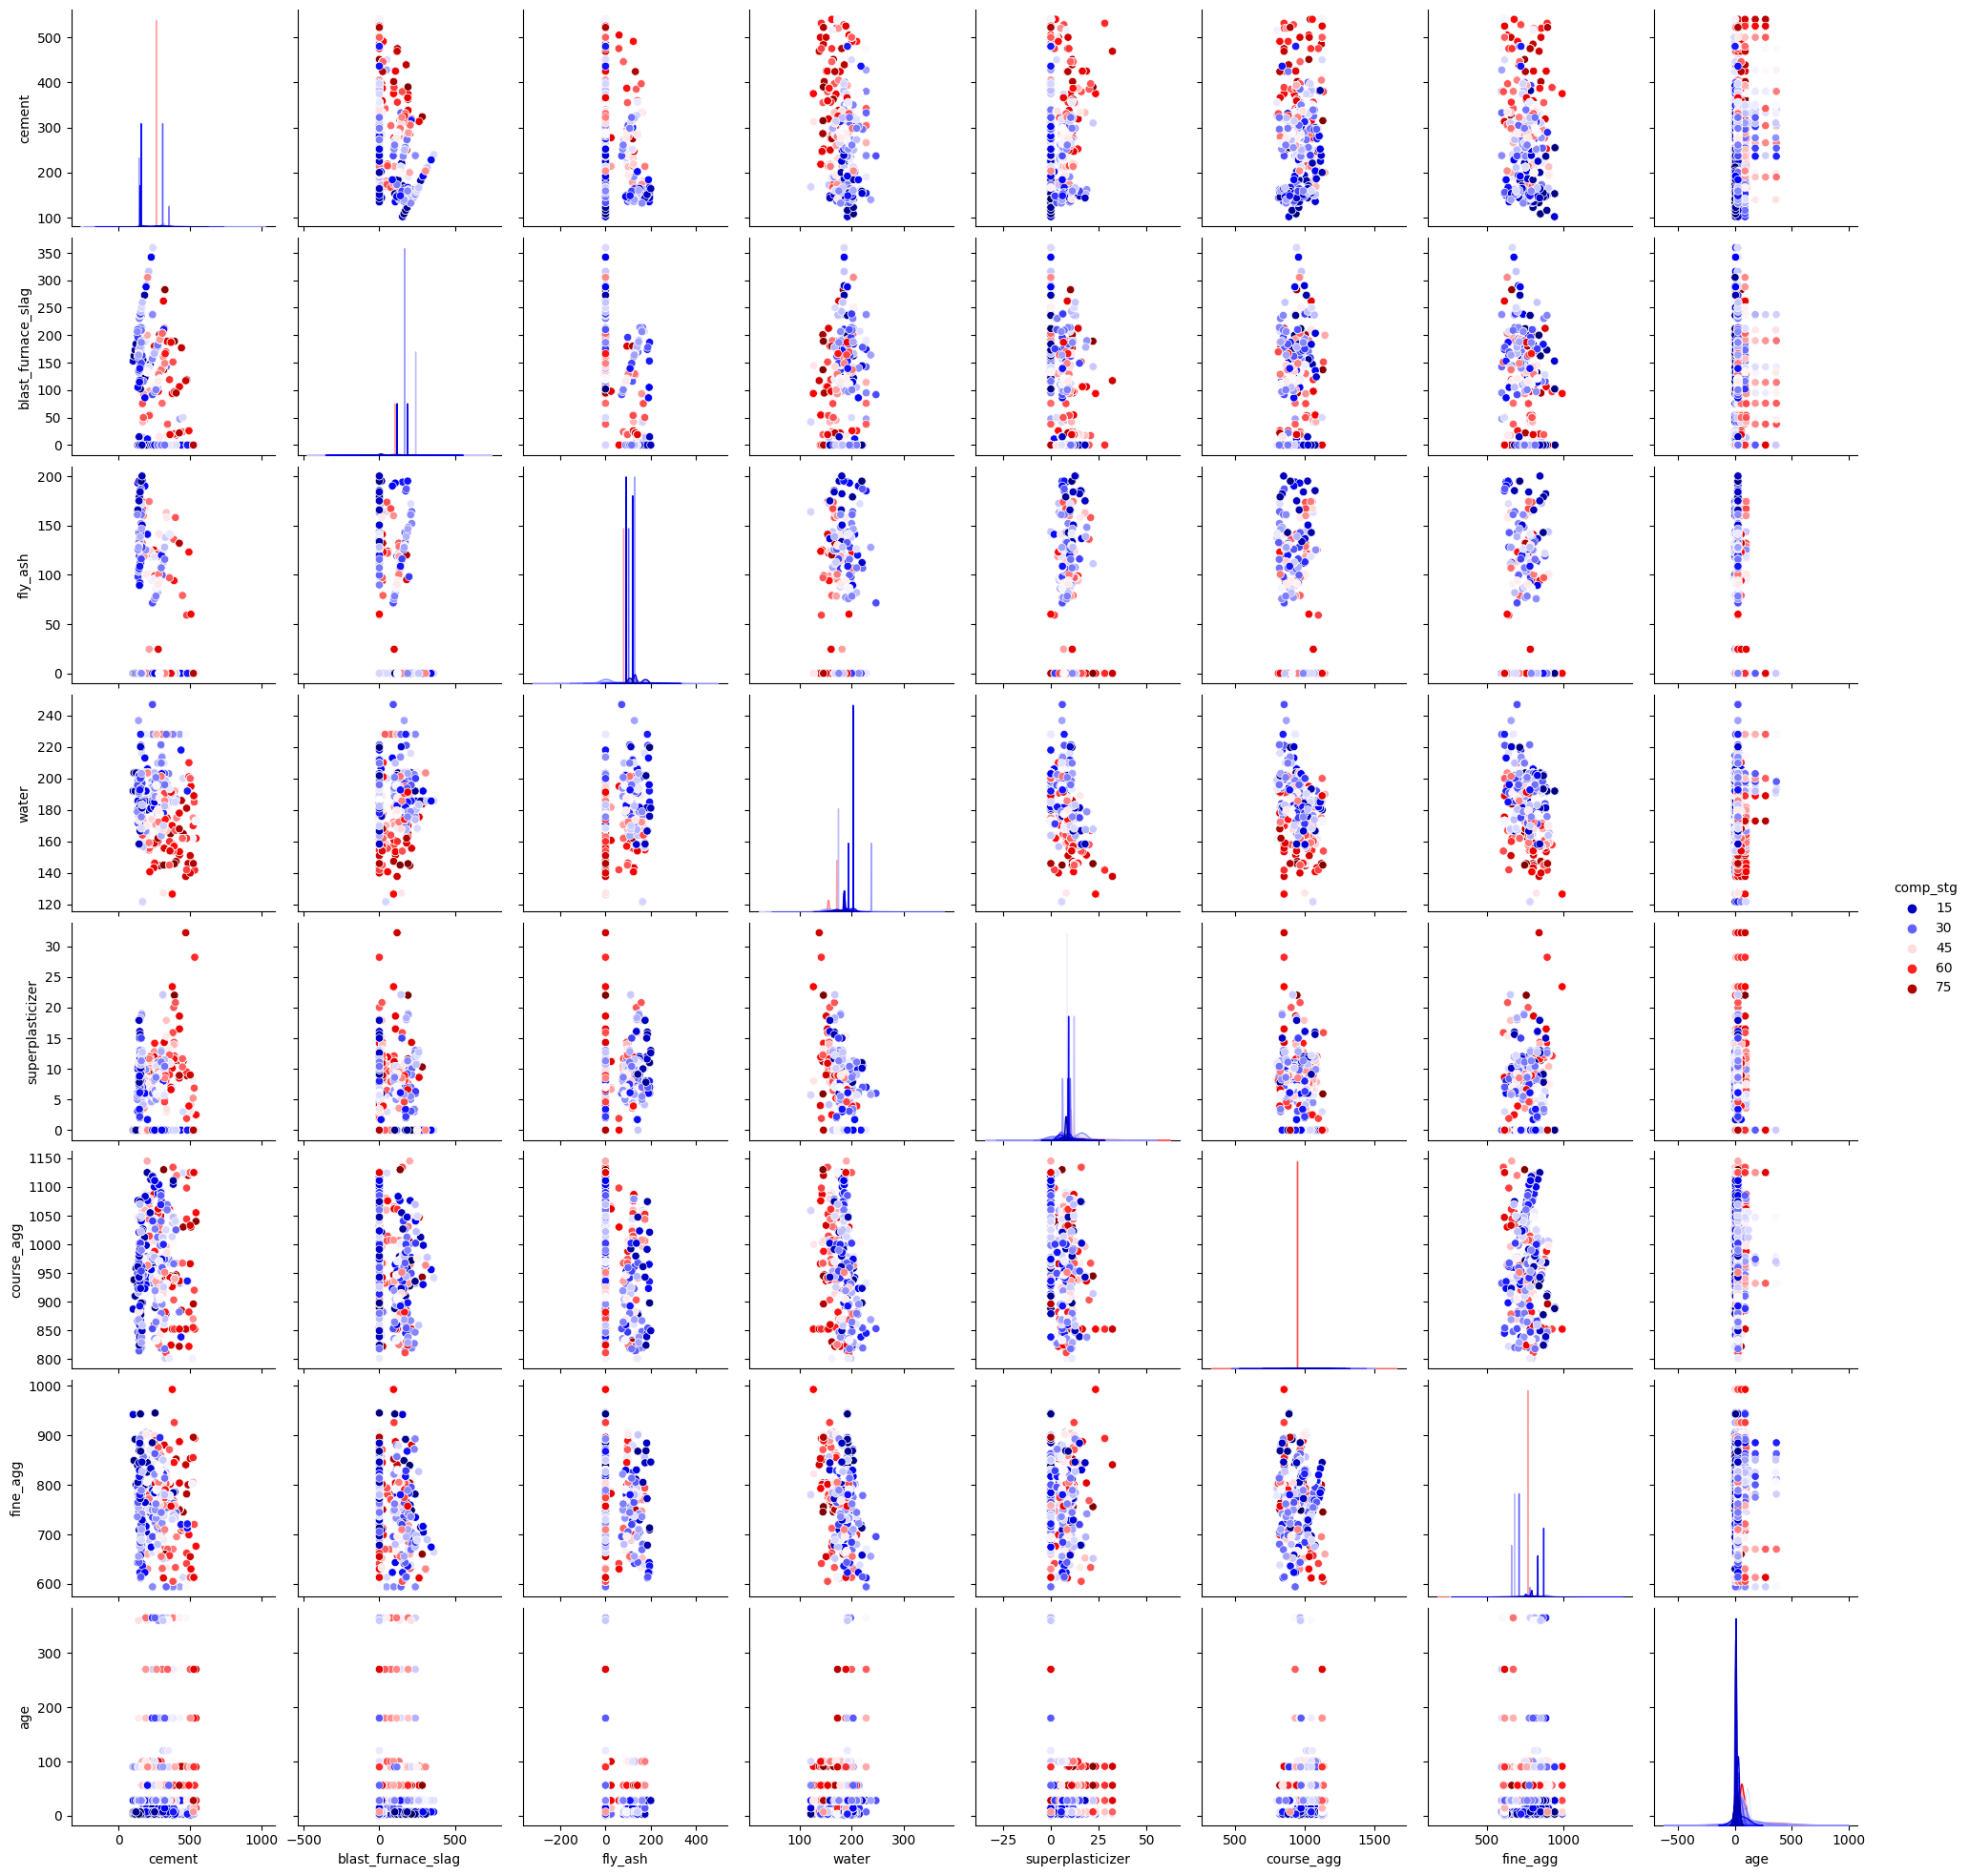

In [7]:
sns.pairplot(data, hue='comp_stg', palette='seismic')

- aparentemente, as maiores correlações são da quantidade de cimento (positiva) e de água (negativa) em relação à força de compressão máxima.
- os dados não parecem ter muitos outliers, exceto por dois valores de `superplasticizer` > 25

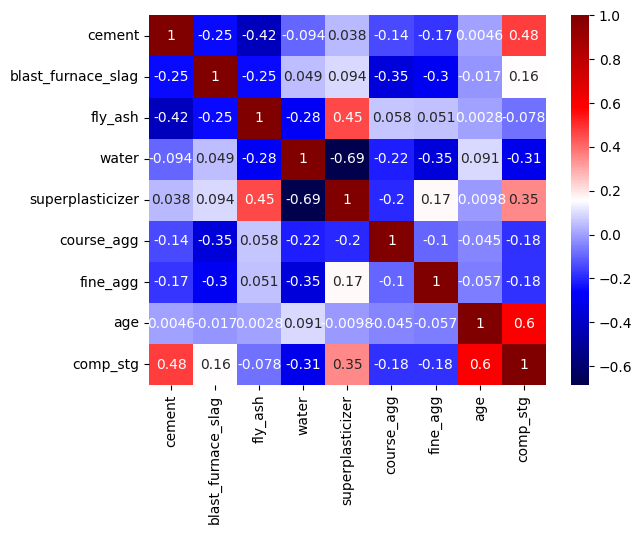

In [8]:
# analisando as correlações numéricas
sns.heatmap(data.corr(method='spearman'), cmap='seismic', annot=True)
plt.show()

In [9]:
# modelagem do sistema 1 - todas as variáveis
def prepare_data_for_model(data, target_name) -> list:

  # passo 1 - separar x e y
  x = data.drop(columns=[target_name])
  y = data[[target_name]]

  # passo 2 - separação dos conjuntos treino, validação e teste
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

  # passo 3 - normalizar dados - x e y
  scalerX = MinMaxScaler(feature_range=(0, 1))
  scalerY = MinMaxScaler(feature_range=(-1, 1))

  scalerX.fit(x_train)
  scalerY.fit(y)

  x = {
      'train': scalerX.transform(x_train),
      'val': scalerX.transform(x_val),
      'test': scalerX.transform(x_test)
  }
  y = {
      'train': scalerY.transform(y_train),
      'val': scalerY.transform(y_val),
      'test': scalerY.transform(y_test)
  }

  return x, y, scalerX, scalerY

In [10]:
# preparando ambos os datasets
TARGET = 'comp_stg'

# dataset 1 - todas as variáveis
x1, y1, scalerX1, scalerY1 = prepare_data_for_model(data, target_name=TARGET)

# dataset 2 - retirando-se a água (menor correlação com a força de compressão)
x2, y2, scalerX2, scalerY2 = prepare_data_for_model(data.drop(columns=['water']), target_name=TARGET)

# dataset 3 - retirando-se o superplasticizer (mais difícil de medir a concentração)
x3, y3, scalerX3, scalerY3 = prepare_data_for_model(data.drop(columns=['superplasticizer']), target_name=TARGET)

In [23]:
class NeuralNetworks:

  # definir constantes
  ACT_HIDDEN = 'relu'
  ACT_OUTPUT = 'tanh'
  OPTIMIZER = 'adam'
  METRICS = ['mean_absolute_error']

  def __init__(self, loss_name) -> None:
    self.LOSS = loss_name

  def create_model(self, x, n_neurons_list) -> None:

    # salvar lista neurons
    self.n_neurons = n_neurons_list

    # definir o modelo sequencial
    self.model = Sequential()

    if len(n_neurons_list) == 1:
      self.model.add(
          Dense(n_neurons_list[0],
                input_shape=(x.shape[1],),
                activation=self.ACT_HIDDEN))
    else:
      for n in n_neurons_list:
        if n == n_neurons_list[0]:
          self.model.add(
              Dense(n,
                    input_shape=(x.shape[1], ),
                    activation=self.ACT_HIDDEN)
          )
        else:
          self.model.add(
              Dense(
                  n,
                  activation=self.ACT_HIDDEN
              )
          )

    # adicionar a camada de saída
    self.model.add(Dense(1, activation=self.ACT_OUTPUT))

  def fit_model(self, x: dict, y: dict, n_epochs, batch_size):

    # armazenar entradas como atributos
    self.N_EPOCHS = n_epochs
    self.BATCH_SIZE = batch_size

    # compilar o modelo
    self.model.compile(loss=self.LOSS,
                       optimizer=self.OPTIMIZER,
                       metrics=self.METRICS)

    # treinar o modelo
    self.history = self.model.fit(
        x['train'],
        y['train'],
        epochs=self.N_EPOCHS,
        batch_size=self.BATCH_SIZE,
        validation_data=(x['val'], y['val'])
    )

  def plot_history(self):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    plt.plot(range(1, self.N_EPOCHS+1), self.history.history[self.METRICS[0]], label='Treinamento')
    plt.plot(range(1, self.N_EPOCHS+1), self.history.history[f'val_{self.METRICS[0]}'], label='Validação')
    plt.legend(loc='best')
    plt.xlabel('Número de Épocas')
    plt.ylabel(self.METRICS[0])
    plt.title(f'Curva de Aprendizado - {self.METRICS[0]}')

    ax = fig.add_subplot(1, 2, 2)
    plt.plot(range(1, self.N_EPOCHS+1), self.history.history['loss'], label='Treinamento')
    plt.plot(range(1, self.N_EPOCHS+1), self.history.history['val_loss'], label='Validação')
    plt.legend(loc='best')
    plt.xlabel('Número de Épocas')
    plt.ylabel('Função de Perda')
    plt.title('Curva de Aprendizado - Função de Perda')
    plt.show()

  def evaluate_metrics(self, x, y, scalerY) -> pd.Series:

    results = {}
    for ds in x:

      # realizar previsões
      yhat = self.model.predict(x[ds])

      # voltar y para as grandezas originais
      y_real = scalerY.inverse_transform(y[ds])
      y_pred = scalerY.inverse_transform(yhat)

      # calcular as métricas
      r2 = r2_score(y_real, y_pred)
      rmse = mean_squared_error(y_real, y_pred, squared=False)
      mae = mean_absolute_error(y_real, y_pred)

      results[f'r2_{ds}'] = r2
      results[f'rmse_{ds}'] = rmse
      results[f'mae_{ds}'] = mae

    # armazenar hiperparâmetros
    results['n_layers'] = len(self.n_neurons)
    arc = ''
    for i in range(len(self.n_neurons)):
      if i == 0:
        arc += f'{self.n_neurons[i]}'
      elif i == len(self.n_neurons)-1:
        arc += f'-{self.n_neurons[i]}'
      else:
        arc += f'-{self.n_neurons[i]}-'
    results['layers'] = arc
    results['epochs'] = self.N_EPOCHS
    results['batch'] = self.BATCH_SIZE
    results['loss'] = self.LOSS

    return pd.Series(results)


In [26]:
# primeiro modelo - dataset 1
loss_list = ['MeanAbsoluteError', 'MeanSquaredError']
nn = NeuralNetworks(loss_list[0])
nn.create_model(x=x1['train'], n_neurons_list=[20, 20])
nn.fit_model(x=x1, y=y1, n_epochs=10, batch_size=64)

Epoch 1/10
11/11 [==============================] - 4s 29ms/step - loss: 0.4349 - mean_absolute_error: 0.4349 - val_loss: 0.3986 - val_mean_absolute_error: 0.3986
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.3705 - mean_absolute_error: 0.3705 - val_loss: 0.3516 - val_mean_absolute_error: 0.3516
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.3418 - mean_absolute_error: 0.3418 - val_loss: 0.3292 - val_mean_absolute_error: 0.3292
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.3271 - mean_absolute_error: 0.3271 - val_loss: 0.3160 - val_mean_absolute_error: 0.3160
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.3154 - mean_absolute_error: 0.3154 - val_loss: 0.3042 - val_mean_absolute_error: 0.3042
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.3046 - mean_absolute_error: 0.3046 - val_loss: 0.2934 - val_mean_absolute_error: 0.2934
Epoch 7/10
11/11 [=========

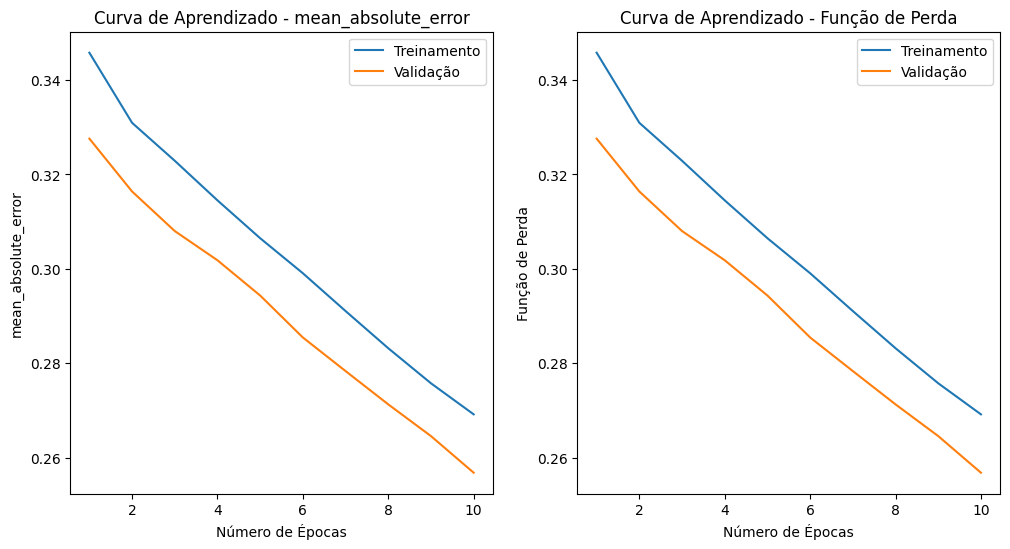

In [13]:
# análise da curva de aprendizado
nn.plot_history()

In [27]:
# avaliação de resultados
nn.evaluate_metrics(x1, y1, scalerY1)

7/7 [==============================] - 0s 2ms/step


r2_train               0.433849
rmse_train            12.683447
mae_train             10.208667
r2_val                 0.424957
rmse_val              12.568655
mae_val                9.996488
r2_test                0.451398
rmse_test             11.989421
mae_test               9.809201
n_layers                      2
layers                    20-20
epochs                       10
batch                        64
loss          MeanAbsoluteError
dtype: object

In [28]:
# mini-seleção de hiperparâmetros - dataset1
results = pd.DataFrame()
for loss in loss_list:
  for n in [5, 10, 20, 50, [5, 5], [10, 10], [5, 10], [10, 20], [20, 50], [50, 50], [20, 50, 50]]:
    for e in [50, 100, 150]:
      # criar o objeto da rede neural
      nn = NeuralNetworks(loss)

      # criar o modelo
      if isinstance(n, list):
        nn.create_model(x=x1['train'], n_neurons_list=n)
      else:
        nn.create_model(x=x1['train'], n_neurons_list=[n])

      # treinar o modelo
      nn.fit_model(x=x1, y=y1, n_epochs=e, batch_size=64)

      # avaliar resultados e armazenar
      aux = nn.evaluate_metrics(x1, y1, scalerY1)

      # armazenar resultados
      results.loc[:, results.shape[1]] = aux

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 89/150
11/11 [==============================] - 0s 8ms/step - loss: 0.0456 - mean_absolute_error: 0.1685 - val_loss: 0.0517 - val_mean_absolute_error: 0.1810
Epoch 90/150
11/11 [==============================] - 0s 9ms/step - loss: 0.0452 - mean_absolute_error: 0.1676 - val_loss: 0.0514 - val_mean_absolute_error: 0.1802
Epoch 91/150
11/11 [==============================] - 0s 8ms/step - loss: 0.0452 - mean_absolute_error: 0.1671 - val_loss: 0.0512 - val_mean_absolute_error: 0.1796
Epoch 92/150
11/11 [==============================] - 0s 8ms/step - loss: 0.0446 - mean_absolute_error: 0.1662 - val_loss: 0.0509 - val_mean_absolute_error: 0.1792
Epoch 93/150
11/11 [==============================] - 0s 10ms/step - loss: 0.0442 - mean_absolute_error: 0.1656 - val_loss: 0.0510 - val_mean_absolute_error: 0.1789
Epoch 94/150
11/11 [==============================] - 0s 7ms/step - loss: 0.0440 - mean_absolute_error: 0.1647 - val_los

In [29]:
results = results.T

In [30]:
results.sort_values(by=['r2_test', 'rmse_test', 'mae_test'], ascending=[False, True, True])

,r2_train,rmse_train,mae_train,r2_val,rmse_val,mae_val,r2_test,rmse_test,mae_test,n_layers,layers,epochs,batch,loss
65,0.938272,4.188069,3.210274,0.855583,6.298647,4.562603,0.891622,5.328924,4.065976,3,20-50--50,150,64,MeanSquaredError
31,0.904128,5.219343,3.642968,0.868178,6.017736,4.317912,0.890551,5.355183,4.028276,3,20-50--50,100,64,MeanAbsoluteError
29,0.91457,4.926926,3.388542,0.860232,6.196451,4.54695,0.888447,5.406428,3.977253,2,50-50,150,64,MeanAbsoluteError
62,0.935676,4.275217,3.180243,0.872656,5.914645,4.405639,0.885034,5.488508,4.051531,2,50-50,150,64,MeanSquaredError
32,0.916857,4.860527,3.425433,0.861752,6.162655,4.41943,0.879778,5.612562,4.19726,3,20-50--50,150,64,MeanAbsoluteError
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,0.637911,10.143292,8.050389,0.584401,10.685033,8.509429,0.604893,10.174819,7.9915,1,5,100,64,MeanSquaredError
45,0.627564,10.287194,8.129604,0.590728,10.603381,8.509295,0.601216,10.222059,8.06125,2,5-5,50,64,MeanSquaredError
37,0.634878,10.185682,8.016596,0.625881,10.137796,8.142496,0.588144,10.388239,8.181392,1,10,100,64,MeanSquaredError
0,0.631094,10.238324,8.09074,0.601646,10.460995,8.441403,0.581405,10.472885,8.241555,1,5,50,64,MeanAbsoluteError
